# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instructions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Import libraries

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.12.0


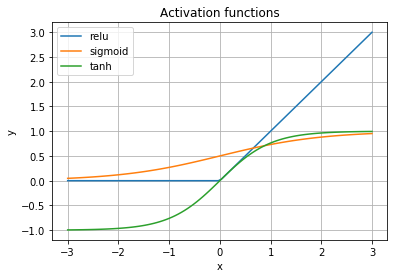

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.12.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use the standard 50,000 images for training and 10,000 images for test.

In [2]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [3]:
# Define max pooling and conv layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: Complete the following functions                                    #
#############################################################################
def flatten(input):
    """
        - input: input tensors
    """
    return tf.layers.flatten(input)

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    return tf.layers.dense(input, num_output)

def norm(input, is_training):
    """
        - input: input tensors
        - is_training: boolean, if during training or not
    """
    return tf.layers.batch_normalization(input, training=is_training)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional neural network

In [4]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.relu3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_training = tf.placeholder(tf.bool, name="is_training")
        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train_op = tf.train.AdamOptimizer(learning_rate=5e-4).minimize(self.loss_op)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.losses.softmax_cross_entropy(labels, logits)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: epoch, Y: training loss
        plt.title('Training Curve')
        plt.plot(losses, '-o', label='Training')
        plt.plot([0.5] * len(losses), 'k--')
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_, self.is_training: False, self.keep_prob: 1.0}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 14.700, accuracy = 0.133
iteration (50): loss = 2.109, accuracy = 0.211
iteration (100): loss = 1.867, accuracy = 0.328
iteration (150): loss = 1.709, accuracy = 0.344
iteration (200): loss = 1.630, accuracy = 0.391
iteration (250): loss = 1.616, accuracy = 0.438
iteration (300): loss = 1.476, accuracy = 0.469
iteration (350): loss = 1.521, accuracy = 0.445
validation for epoch 0
-  epoch 0: validation accuracy = 0.488
train for epoch 1
iteration (400): loss = 1.267, accuracy = 0.523
iteration (450): loss = 1.394, accuracy = 0.516
iteration (500): loss = 1.443, accuracy = 0.445
iteration (550): loss = 1.183, accuracy = 0.609
iteration (600): loss = 1.415, accuracy = 0.477
iteration (650): loss = 1.343, accuracy = 0.539
iteration (700): loss = 1.367

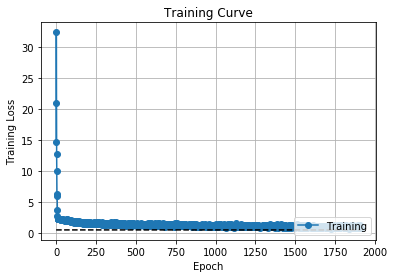

***** test accuracy: 0.585
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [70]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/gpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
    with tf.device('/cpu:0'):
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.  
For GPU usage, simply change the following line of the training block:  
from `with tf.device('/cpu:0')` to `with tf.device('/GPU:0')`  
and you can set your desired device number  

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80%, you will get 5 extra points.

In [5]:
# Data augmentation procedures
def rotate_images(imgs, labels, n_rotations=3):
    """Rotate the images 90deg for 4 orientations of each image"""
    
    assert(n_rotations >= 0 and n_rotations <= 3)
    rot_imgs = imgs.copy()
    labels = np.tile(labels, n_rotations+1)
    for i in range(1, n_rotations+1):
        rot_imgs = np.concatenate((rot_imgs, np.rot90(imgs, i, axes=(2,1))))
    return rot_imgs, labels

def hflip_images(imgs, labels):
    """Flip images horizontally"""
    
    flipped_imgs = np.fliplr(imgs)
    labels = np.tile(labels, 2)
    return np.concatenate((imgs, flipped_imgs)), labels

def get_shift(dim, n):
    if n > 0:
        return int(np.floor(n*dim))
    return int(np.ceil(n*dim))

def translate_imgs(placeholder, imgs, x, y, background):
    if x > 0:
        placeholder[:,:,x:,:] = imgs[:,:,:-x,:]
    else:
        placeholder[:,:,:x,:] = imgs[:,:,-x:,:]
    if y > 0:
        placeholder[:,y:,:,:] = imgs[:,:-y,:,:]
    else:
        placeholder[:,:y,:,:] = imgs[:,-y:,:,:]
    if x > 0:
        placeholder[:,:,:x,:] = background
    else:
        placeholder[:,:,x:,:] = background
    if y > 0:
        placeholder[:,:y,:,:] = background
    else:
        placeholder[:,y:,:,:] = background
    return placeholder

def random_translate(imgs, labels, n_translations, background=1.0):
    """Translate images in random directions"""
    
    dim = imgs.shape[1]
    translations = np.random.random((n_translations, 2))*0.1 + 0.1
    directions = np.random.choice((-1,1), (n_translations, 2))
    translations = translations * directions
    tr_imgs = imgs.copy()
    labels = np.tile(labels, n_translations+1)
    for tr in translations:
        _tr_imgs = np.empty_like(imgs)
        x_shift = get_shift(dim, tr[0])
        y_shift = get_shift(dim, tr[1])
        _tr_imgs = translate_imgs(_tr_imgs, imgs, x_shift, y_shift, background)
        tr_imgs = np.concatenate((tr_imgs, _tr_imgs))
    return tr_imgs, labels

def shuffle_data(imgs, labels):
    idx = np.arange(labels.shape[0])
    np.random.shuffle(idx)
    return imgs[idx], labels[idx]

def data_augmentation(imgs, labels, n_translations):
    #rot_X_train, rot_Y_train = rotate_images(imgs, labels)
    tr_X_train, tr_Y_train = random_translate(imgs, labels, n_translations=n_translations)
    flip_X_train, flip_Y_train = hflip_images(tr_X_train, tr_Y_train)
    aug_X_train, aug_Y_train = shuffle_data(flip_X_train, flip_Y_train)
    return aug_Y_train.shape[0], aug_X_train, aug_Y_train

In [10]:
import time

In [18]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 10
        self.batch_size = 256
        self.log_step = 1000
        
    def residual_unit(self, input, kernel_size, stride, n_kernels, name):
        with tf.variable_scope(name+'conv1'):
            conv1 = conv2d(input, kernel_size, stride, n_kernels)
            norm1 = norm(conv1, is_training=self.is_training)
            relu1 = tf.nn.relu(norm1)
        
        with tf.variable_scope(name+'conv2'):
            conv2 = conv2d(relu1, kernel_size, stride, n_kernels)
            norm2 = norm(conv2, is_training=self.is_training)
            relu2 = tf.nn.relu(norm2)
            
        norm3 = norm(relu2+input, is_training=self.is_training)
        return tf.nn.relu(norm3)
    
    def residual_unitb(self, input, kernel_size, stride, n_kernels, name):
        with tf.variable_scope(name+'conv1'):
            pconv = conv2d(input, 1, 1, n_kernels)
        
        with tf.variable_scope(name+'conv2'):
            conv1 = conv2d(input, kernel_size, stride, n_kernels)
            norm1 = norm(conv1, is_training=self.is_training)
            relu1 = tf.nn.relu(norm1)
        
        with tf.variable_scope(name+'conv3'):
            conv2 = conv2d(relu1, kernel_size, stride, n_kernels)
            norm2 = norm(conv2, is_training=self.is_training)
            relu2 = tf.nn.relu(norm2)
        
        norm3 = norm(relu2+pconv, is_training=self.is_training)
        return tf.nn.relu(norm3)
    
    def conv_block(self, input, kernel_size, stride, filters, name):
        with tf.variable_scope(name):
            conv1 = conv2d(input, kernel_size, stride, filters)
            norm1 = norm(conv1, is_training=self.is_training)
            relu1 = tf.nn.relu(norm1)
        return relu1

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)
        print('input layer: ' + str(self.X.get_shape()))
        
        self.conv1 = self.conv_block(self.X, 7, 2, 64, 'conv1')
        self.pool1 = max_pool(self.conv1, 3, 2)
        self.conv2 = self.conv_block(self.pool1, 5, 1, 64, 'conv2')
        self.pool2 = max_pool(self.conv2, 2, 2)
        self.conv3 = self.conv_block(self.pool2, 3, 1, 128, 'conv3')
        self.pool3 = max_pool(self.conv3, 2, 2)
        self.conv4 = self.conv_block(self.pool3, 3, 1, 256, 'conv4')
        self.pool4 = max_pool(self.conv4, 2, 2)
        self.conv5 = self.conv_block(self.pool4, 3, 1, 512, 'conv5')
        self.pool5 = max_pool(self.conv5, 2, 2)
        """
        with tf.variable_scope('res1'):
            self.res1 = self.residual_unit(self.pool1, 3, 1, 64, name='res1')
            
        with tf.variable_scope('res2'):
            self.res2 = self.residual_unit(self.res1, 3, 1, 64, name='res2')
            
        with tf.variable_scope('res3'):
            self.res3 = self.residual_unitb(self.res2, 3, 1, 128, name='res3')
            
        with tf.variable_scope('res4'):
            self.res4 = self.residual_unit(self.res3, 3, 1, 128, name='res4')
            
        with tf.variable_scope('res5'):
            self.res5 = self.residual_unitb(self.res4, 3, 1, 256, name='res5')
            
        with tf.variable_scope('res6'):
            self.res6 = self.residual_unit(self.res5, 3, 1, 256, name='res6')
            
        with tf.variable_scope('res7'):
            self.res7 = self.residual_unitb(self.res6, 3, 1, 512, name='res7')
            
        with tf.variable_scope('res8'):
            self.res8 = self.residual_unit(self.res7, 3, 1, 512, name='res8')
            
        with tf.variable_scope('pool2'):
            self.pool2 = tf.reduce_mean(self.res8, axis=[1,2])
        """

        self.flat = flatten(self.pool5)

        with tf.variable_scope('fc1'):
            self.fc1 = fc(self.flat, 384)
            self.fcnorm1 = norm(self.fc1, is_training=self.is_training)
            self.fcrelu1 = tf.nn.relu(self.fcnorm1)
            self.dropout1 = tf.nn.dropout(self.fcrelu1, keep_prob=self.keep_prob)
            
        #with tf.variable_scope('fc2'):
        #    self.fc2 = fc(self.dropout1, 128)
        #    self.fcnorm2 = norm(self.fc2, is_training=True)
        #    self.fcrelu2 = tf.nn.relu(self.fcnorm2)
        #    self.dropout2 = tf.nn.dropout(self.fcrelu2, keep_prob=self.keep_prob)
        
        #with tf.variable_scope('fc3'):
        #    self.fc3 = fc(self.dropout2, 10)
        with tf.variable_scope('fc2'):
            self.fc2 = fc(self.dropout1, 10)
            
        # Return the last layer
        return self.fc2
    
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        val_accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            start_time = time.time()
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                
                augN, augX, augY = data_augmentation(X_, Y_, n_translations=5)
                for j in range(augN//self.batch_size):
                    augX_ = augX[j * self.batch_size:(j+1)*self.batch_size][:]
                    augY_ = augY[j * self.batch_size:(j+1)*self.batch_size]

                    #############################################################################
                    # TODO: You can change feed data as you want                                #
                    #############################################################################
                    feed_dict = {self.X: augX_, self.Y: augY_, self.is_training: True, self.keep_prob: 0.5}
                    #############################################################################
                    #                             END OF YOUR CODE                              #
                    #############################################################################
                    fetches = [self.train_op, self.loss_op, self.accuracy_op]

                    _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                    losses.append(loss)
                    accuracies.append(accuracy)

                    if step % self.log_step == 0:
                        print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                            (step, loss, accuracy))
                    step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            end_time = time.time()
            print('-  epoch %d: validation accuracy = %.3f -- %.3f s/epoch' % (epoch, val_accuracy, end_time-start_time))
            val_accuracies.append(val_accuracy)
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: epoch, Y: training loss
        plt.title('Validation Accuracy')
        plt.plot(val_accuracies, '-o', label='Val')
        plt.plot([0.5] * len(val_accuracies), 'k--')
        plt.xlabel('Epoch')
        plt.ylabel('Validation Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [19]:
# Clear old computation graphs
tf.reset_default_graph()

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/gpu:0'):
        model = YourModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
    #with tf.device('/cpu:0'):
        # Save your model
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

-----  Your model  -----
input layer: (?, 32, 32, 3)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 3.060, accuracy = 0.113
iteration (1000): loss = 1.409, accuracy = 0.508
iteration (2000): loss = 1.120, accuracy = 0.617
validation for epoch 0
-  epoch 0: validation accuracy = 0.508 -- 44.450 s/epoch
train for epoch 1
iteration (3000): loss = 1.263, accuracy = 0.523
iteration (4000): loss = 0.861, accuracy = 0.672
validation for epoch 1
-  epoch 1: validation accuracy = 0.589 -- 41.973 s/epoch
train for epoch 2
iteration (5000): loss = 0.969, accuracy = 0.645
iteration (6000): loss = 0.979, accuracy = 0.629
validation for epoch 2
-  epoch 2: validation accuracy = 0.611 -- 42.031 s/epoch
train for epoch 3
iteration (7000): loss = 0.815, accuracy = 0.703
iteration (8000): loss = 0.677, accuracy = 0.777
iteration (9000): loss = 0.724, accuracy = 0.754
validation for epoch 3
-  epoch 3: validation accuracy = 0.605 -- 42.397 s/epoch
train for epoch 4
iteration (10000)

KeyboardInterrupt: 

In [ ]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")